In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
!pwd

/Users/anabergues/Documents/Study/2021-DSR/Portfolio/Model-test


In [10]:
# Fixing format of the data
def enc_label(label):
    code = 0
    if label == "right-turn":
        code = 1
    if label == "side":
        code = 2
    if label == "cuban-basic":
        code = 3
    if label == "suzie-q":
        code = 4
    return code

In [5]:
# Define hyperparameters
BATCH_SIZE = 64
EPOCHS = 10

MAX_SEQ_LENGTH = 30   # number of frames per figure
NUM_FEATURES = 50     # number of join coordinates
no_sample = 20        # number of examples

# Import the data
PATH_DATA = "Data_concat.csv"
data = pd.read_csv(PATH_DATA)

/opt/anaconda3/envs/model/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (78,79) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
data.head()

,clip_name,frame_nr,person_id,nose_x,nose_y,neck_x,neck_y,rshoulder_x,rshoulder_y,relbow_x,...,rear_v,lear_v,lbigtoe_v,lsmalltoe_v,lheal_v,rbigtoe_v,rsmalltoe_v,rheal_v,label,status
0,1p_Artur_05122021_chreo1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1p_Artur_05122021_chreo1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1p_Artur_05122021_chreo1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1p_Artur_05122021_chreo1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1p_Artur_05122021_chreo1,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Data preprocessing, get the input X and the label y
ind_start = data[data['status'] == "S"].index.tolist()
ind_end = data[data['status'] == "E"].index.tolist()

# Take intervals between consecutive "S", they define one figure
X = []
y = []

for i in range(no_sample):
    X.append(data.iloc[ind_start[i]: ind_end[i], 3:-27])  # the last 25 (visibility ) + 2
    y.append(data.loc[ind_start[i], 'label'])

In [11]:
# select frames from the interval TODO should be uniform
ind_samp = []

for i in range(no_sample):
    # Uniform
    aux = np.linspace(ind_start[i]
                      , ind_end[i]
                      , MAX_SEQ_LENGTH
                      , endpoint=False).astype(int)

    # random
    # aux = np.random.randint(ind_start[i], ind_end[i], MAX_SEQ_LENGTH)
    # aux.sort()
    ind_samp.append(aux)

# TODO: decide between random and uniform sampling

# Changing format of the data to be compatible with Tensor Flow
X_train = [x.loc[ind_samp[ind], :].to_numpy() for (ind, x) in enumerate(X)]
X_train = np.array(X_train)
X_train = X_train.reshape(no_sample, MAX_SEQ_LENGTH, NUM_FEATURES).astype("float32")
# TODO: decide of the X values need to be normalized
y_train = [enc_label(x) for x in y]
y_train = np.array(y_train).astype("float32")

In [12]:
# Build the model
# TODO: use functional way to build the model
# eg: https://keras.io/examples/vision/video_classification/ (The sequence model)
model = models.Sequential()
model.add(layers.Flatten(input_shape=(MAX_SEQ_LENGTH, NUM_FEATURES)))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(5, activation="softmax"))
model.summary()

# Compile the model
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1500)              0         
                                                                 
 dense (Dense)               (None, 128)               192128    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 200,709
Trainable params: 200,709
Non-trainable params: 0
_________________________________________________________________


2021-12-10 14:53:46.047652: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
# Check the trainning accuracy
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=5,
    validation_data=(X_train, y_train)
)

Epoch 1/10
4/4 [==============================] - 0s 67ms/step - loss: 29.7528 - accuracy: 0.6000 - val_loss: 48.6340 - val_accuracy: 0.5500
Epoch 2/10
4/4 [==============================] - 0s 22ms/step - loss: 45.4193 - accuracy: 0.5500 - val_loss: 30.8033 - val_accuracy: 0.6000
Epoch 3/10
4/4 [==============================] - 0s 17ms/step - loss: 28.9423 - accuracy: 0.5500 - val_loss: 17.5796 - val_accuracy: 0.7500
Epoch 4/10
4/4 [==============================] - 0s 22ms/step - loss: 24.0074 - accuracy: 0.6500 - val_loss: 19.2526 - val_accuracy: 0.7000
Epoch 5/10
4/4 [==============================] - 0s 16ms/step - loss: 21.6207 - accuracy: 0.6500 - val_loss: 2.9687 - val_accuracy: 0.9000
Epoch 6/10
4/4 [==============================] - 0s 31ms/step - loss: 8.5515 - accuracy: 0.8000 - val_loss: 20.2477 - val_accuracy: 0.7000
Epoch 7/10
4/4 [==============================] - 0s 35ms/step - loss: 32.8017 - accuracy: 0.7000 - val_loss: 43.0118 - val_accuracy: 0.6000
Epoch 8/10
4/4 

In [14]:
def render_history(history):
    plt.plot(history["loss"], label="loss")
    #plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.title("Train losses")
    plt.show()
    plt.close()

    plt.plot(history["accuracy"], label="accuracy")
    #plt.plot(history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.title("Train accuracies")
    plt.show()
    plt.close()

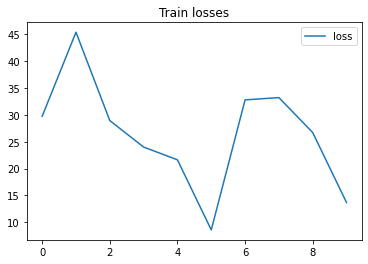

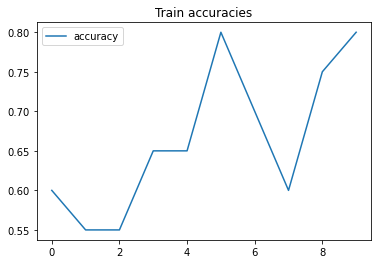

In [18]:
render_history(history.history)